In [8]:
import boto3
import awswrangler as wr
import pandas as pd
accessKeys = pd.read_csv("../../quant-bears_accessKeys.csv")
session = boto3.Session(
	aws_access_key_id=accessKeys.loc[0, "Access key ID"],
	aws_secret_access_key=accessKeys.loc[0, "Secret access key"]
)

s3_collection_path = "s3://quant-bears-data-collection/raw-data/"
s3_price_collection_path = "s3://quant-bears-data-collection/raw-resolved-price/"

In [9]:
data_sources = ["seekingAlpha.seekingAlphaBulkMetrics", "gurufocus"]

sources_dict = dict((source, wr.s3.list_objects(s3_collection_path + source + "/", boto3_session=session)) for source in data_sources)

In [10]:
from tqdm import tqdm

In [12]:
df_dict = {}
for source in data_sources:
	dfs = []
	print(source)
	for path in tqdm(sources_dict[source]):
		new_df = wr.s3.read_parquet(path, boto3_session=session)
		new_df["date"] = path.split("/")[-1].split(".")[0]
		dfs.append(new_df)

	df_dict[source] = pd.concat(dfs, axis = 0)

seekingAlpha.seekingAlphaBulkMetrics


  0%|          | 0/7 [00:00<?, ?it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_82380/1571599482.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 14%|█▍        | 1/7 [00:00<00:04,  1.45it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/ipykernel_82380/1571599482.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_df["date"] = path.split("/")[-1].split(".")[0]
 29%|██▊       | 2/7 [00:01<00:03,  1.56it/s]/var/folders/tq/51dxx6813y7g8dg44h973dmr0000gn/T/

gurufocus


100%|██████████| 7/7 [00:04<00:00,  1.67it/s]


In [13]:
joined_df = pd.concat([df.set_index(["date", "ticker"]) for df in df_dict.values()], axis = 1)
joined_df.shape

(11109, 337)

In [14]:
joined_df.index

MultiIndex([('2023-09-28',    'A'),
            ('2023-09-28',   'AA'),
            ('2023-09-28',  'AAL'),
            ('2023-09-28',  'AAP'),
            ('2023-09-28', 'AAPL'),
            ('2023-09-28', 'ABBV'),
            ('2023-09-28', 'ABCL'),
            ('2023-09-28', 'ABCM'),
            ('2023-09-28', 'ABEV'),
            ('2023-09-28',  'ABM'),
            ...
            ('2023-10-06',  'ZIM'),
            ('2023-10-06', 'ZION'),
            ('2023-10-06',  'ZIP'),
            ('2023-10-06',   'ZM'),
            ('2023-10-06', 'ZNTL'),
            ('2023-10-06',   'ZS'),
            ('2023-10-06',  'ZTO'),
            ('2023-10-06',  'ZTS'),
            ('2023-10-06',  'ZUO'),
            ('2023-10-06',  'ZWS')],
           names=['date', 'ticker'], length=11109)

In [16]:
nan_pct = joined_df.isna().sum() / joined_df.shape[0]

<Axes: >

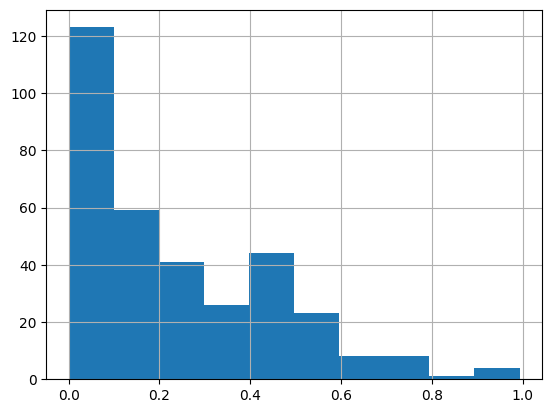

In [17]:
nan_pct.hist()

<Axes: >

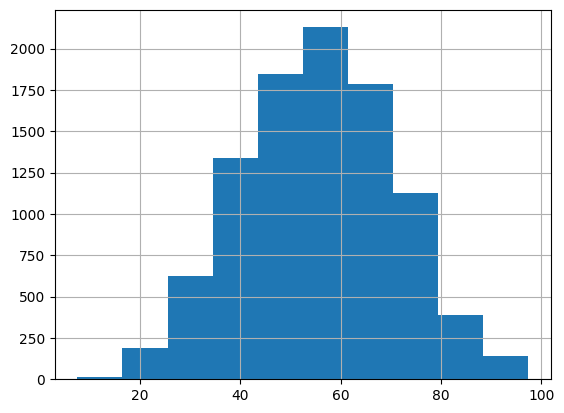

In [35]:
test_median_fill = joined_df["analysts_up_percent_avg_5y"]
test_median_fill.hist()

In [37]:
test_median_fill.fillna(test_median_fill.median()).std()

14.181596172742932

In [41]:
test_median_fill.fillna(test_median_fill.median()).std() / test_median_fill.std()

0.9287906270938736

In [73]:
def stddev_diff(col):
	stddev_median_diff = col.fillna(col.median()).std() / col.std()
	stddev_zero_diff = col.fillna(0.).std() / col.std()
	return (stddev_median_diff, stddev_zero_diff, "median" if stddev_median_diff <= stddev_zero_diff else "zero")


In [74]:
float_df = joined_df.select_dtypes([float, int])
stddev_diffs = float_df.apply(stddev_diff).rename(index = {0: "median_fill", 1: "zero_fill", 2: "method"})

<Axes: >

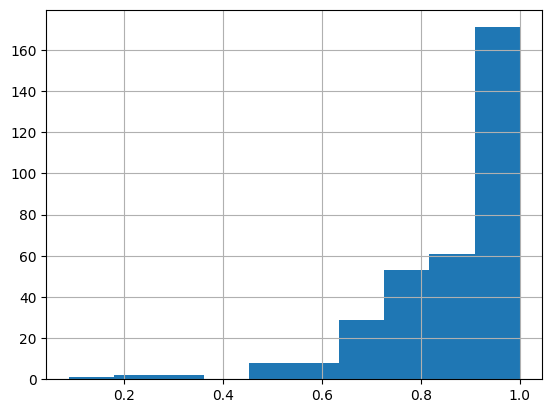

In [76]:
stddev_diffs.loc["median_fill"].hist()

<Axes: >

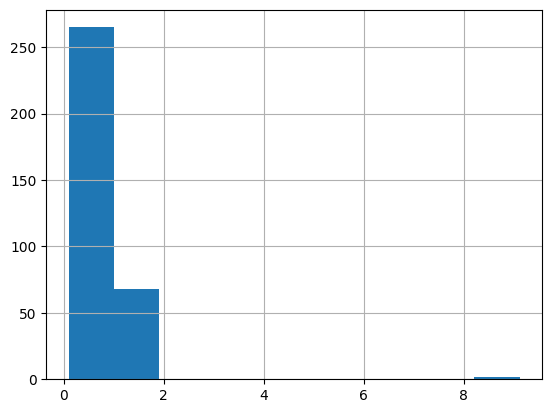

In [77]:
stddev_diffs.loc["zero_fill"].hist()

In [87]:
stddev_diffs.T

,median_fill,zero_fill,method
altman_z_score,0.87616,0.888796,median
analysts_down,0.991211,0.997444,median
analysts_down_percent,0.988452,1.005208,median
analysts_down_percent_avg_5y,0.928791,1.364143,median
analysts_up,0.991011,0.997099,median
...,...,...,...
Price-to-FFO,0.251876,0.263268,median
Volume,0.856113,0.876018,median
Avg_Volume__2M_,0.855917,0.876505,median
Market_Cap,0.851885,0.854509,median


In [88]:
dist_from_1 = (1. - stddev_diffs.T[["median_fill", "zero_fill"]]).abs()
dist_from_1["min_diff"] = dist_from_1.min(axis = 1)

<Axes: >

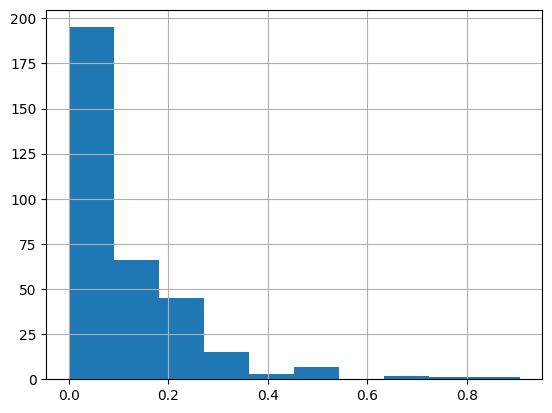

In [90]:
dist_from_1["min_diff"].hist()

In [91]:
(dist_from_1["min_diff"] >= .1).sum()

129

In [92]:
# Amount of features whose difference in standard deviation after median or zero fill is less than 10% of original standard deviation
(dist_from_1["min_diff"] < .1).sum()

206

<Axes: >

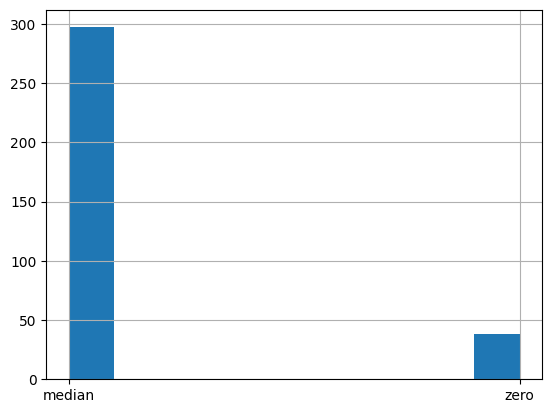

In [98]:
stddev_diffs.loc["method"].hist()

<Axes: >

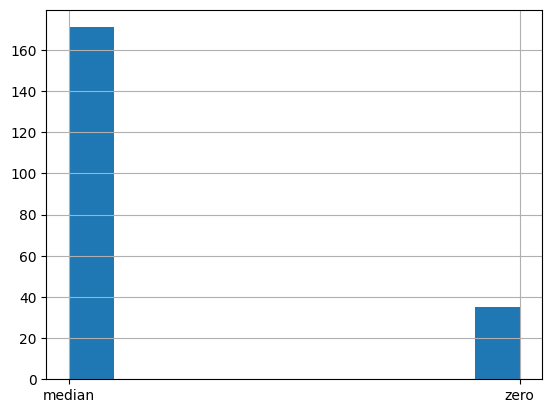

In [97]:
stddev_diffs.T[dist_from_1["min_diff"] < .1]["method"].hist()

In [104]:
stddev_diffs.T[dist_from_1["min_diff"] < .1]

,median_fill,zero_fill,method
analysts_down,0.991211,0.997444,median
analysts_down_percent,0.988452,1.005208,median
analysts_down_percent_avg_5y,0.928791,1.364143,median
analysts_up,0.991011,0.997099,median
analysts_up_percent,0.988452,1.008689,median
...,...,...,...
EV-to-Revenue,0.990592,0.990614,median
EV-to-Forward-Revenue,0.954,0.95432,median
EV-to-FCF,0.999415,0.999415,zero
Price-to-Median-PS-Value,0.80156,1.003722,median


In [115]:
def fill_median_or_zero_by_thresh(df: pd.DataFrame, thresh: float):
	def stddev_diff(col):
		stddev_median_diff = col.fillna(col.median()).std() / col.std()
		stddev_zero_diff = col.fillna(0.).std() / col.std()
		return (stddev_median_diff, stddev_zero_diff, "median" if stddev_median_diff <= stddev_zero_diff else "zero")
	
	float_df = df.select_dtypes([int, float])
	stddev_diffs = float_df.apply(stddev_diff).rename(index = {0: "median_fill", 1: "zero_fill", 2: "method"})
	dist_from_1 = (1. - stddev_diffs.T[["median_fill", "zero_fill"]]).abs()
	dist_from_1["min_diff"] = dist_from_1.min(axis = 1)
	passed_diffs = stddev_diffs.T[dist_from_1["min_diff"] <= thresh]

	def apply_imputation(col: pd.Series):
		if col.name in passed_diffs.index:
			method = passed_diffs.loc[col.name]["method"]
			if method == "zero":
				return col.fillna(0.)
			elif method == "median":
				return col.fillna(col.median())
		return col
	
	return df.apply(apply_imputation)

In [116]:
"foobar" in joined_df.columns

False

In [117]:
imputed_df = fill_median_or_zero_by_thresh(joined_df, 0.1)
imputed_df

altman_z_score  analysts_down  analysts_down_percent  \
date       ticker                                                         
2023-09-28 A             6.153144           15.0             100.000000   
           AA            1.401235            7.0             100.000000   
           AAL           0.862385            9.0              52.941177   
           AAP           2.266178           15.0             100.000000   
           AAPL          7.639575            8.0              22.222221   
...                           ...            ...                    ...   
2023-10-06 ZS            4.317831            4.0              12.121212   
           ZTO           4.868613            2.0              16.666666   
           ZTS           7.658604            2.0              16.666666   
           ZUO           0.155362            0.0               0.000000   
           ZWS           2.461064            0.0               0.000000   

                   analysts_down_percent_avg_5y  analysts_up  \
date       ticker                                              
2023-09-28 A                          12.759212          0.0   
           AA                         60.404625          0.0   
           AAL                        53.991806          8.0   
           AAP                        39.274876          0.0   
           AAPL                       23.935060         28.0   
...                                         ...          ...   
2023-10-06 ZS                         16.023056         29.0   
           ZTO                        50.419450         10.0   
           ZTS                        28.783968         10.0   
           ZUO                        24.833600          6.0   
           ZWS                        40.450850          7.0   

                   analysts_up_percent  analysts_up_percent_avg_5y  \
date       ticker                                                    
2023-09-28 A                  0.000000                   87.240790   
           AA                 0.000000                   39.595375   
           AAL               47.058823                   46.008194   
           AAP                0.000000                   60.725124   
           AAPL              77.777780                   76.064940   
...                                ...                         ...   
2023-10-06 ZS                87.878784                   83.976944   
           ZTO               83.333336                   49.580550   
           ZTS               83.333336                   71.216034   
           ZUO              100.000000                   75.166400   
           ZWS              100.000000                   59.549150   

                   assets_turnover  assets_turnover_avg_5y  authors_count  \
date       ticker                                                           
2023-09-28 A              0.661089                0.601508            4.0   
           AA             0.728491                0.757975            2.0   
           AAL            0.782322                0.599356            7.0   
           AAP            0.917976                0.929945            8.0   
           AAPL           1.143769                0.929182           36.0   
...                            ...                     ...            ...   
2023-10-06 ZS             0.502082                0.490827           10.0   
           ZTO            0.498667                0.510326            1.0   
           ZTS            0.597550                0.566958            3.0   
           ZUO            0.618500                0.803774            3.0   
           ZWS            0.770831                0.575590            1.0   

                   ...                            area  \
date       ticker  ...                                   
2023-09-28 A       ...  Medical Diagnostics & Research   
           AA      ...                 Metals & Mining   
           AAL     ...                  Transportation   
       

In [120]:
imputed_df.isna().sum().sort_values()

oper_income_fy1_market_cap        0
levered_fcf_margin                0
levered_fcf_margin_avg_5y         0
levered_free_cash_flow            0
levered_free_cash_flow_yoy        0
                              ...  
Price-to-Net-Cash              9852
impliedmarketcap              10306
cf_payout_avg_5y              10385
Price-to-FFO                  10422
peg_gaap_avg_5y               11030
Length: 337, dtype: int64